In [1]:
import numpy as np
import seaborn as sns
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import automated_design
import analysis
import run_models
import hitting_time

tomov_interop could not load matlab


R[write to console]: Loading required package: dfidx

R[write to console]: 
Attaching package: ‘dfidx’


R[write to console]: The following object is masked from ‘package:stats’:

    filter




In [2]:
graphs = automated_design.download_bdm_graphs_8c()

In [3]:
def corrcoef_stdhack(arr):
    '''
    When doing graph-wise cross-algo correlations, need to avoid nan's when SD is 0, since algorithms at time predict uniform.
    '''
    # We take care to check for predictions that are numerically close to uniform, since they otherwise can result in nonsensical correlations.
    def _is_uniform(a):
        return np.allclose(a, a[0])
    is_uni = np.array([_is_uniform(a) for a in arr], dtype=bool)

    # We intentionally allow NaN correlations that result from division by SD of 0.
    with np.errstate(invalid='ignore'):
        c = np.corrcoef(arr)
    c[is_uni, :] = np.nan
    c[:, is_uni] = np.nan
    return c

eps = 1e-8
assert np.allclose(corrcoef_stdhack(np.array([
    [0, 0+eps, 0-eps],
    np.arange(3),
    -np.arange(3),
])), np.array([
    [np.nan, np.nan, np.nan],
    [np.nan, 1, -1],
    [np.nan, -1, 1],
]), equal_nan=True)

In [4]:
def vector_corr(a, b):
    c = corrcoef_stdhack(np.array([a, b]))
    assert c.shape == (2, 2)
    return c[0, 1]

assert vector_corr(np.arange(3), -np.arange(3)) == -1

# What is relationship between RRTD-RW with varying approximation vs QCut/DC?

## First, ensure regular graphs with rank 1 RRTD-RW are correlated to QCut

In [5]:
regular_graphs = [
    g
    for g in graphs
    if all(
        len(g.actions(s)) == len(g.actions(g.state_list[0]))
        for s in g.state_list)
]

corrs = []
for g in regular_graphs:
    corrs.append(vector_corr(
        run_models.rw_spectral_rank1(g)['scores'],
        run_models.qcut(g)['scores'],
    ))

np.nanmean(corrs)

1.0

## Now, do a more general check across graphs.

In [6]:
def rw_correlations(gs, base_models, models):
    def _get_predictions(model, g):
        return model.model(g)['scores']
        # In initial submission, this figure was incorrectly generated with the following distribution:
        # return getattr(run_models.SINGLETON, model.key)(g)['scores']

    model_to_corrs = {m.key: [] for m in base_models}

    for gi, g in enumerate(tqdm(gs)):
        model_preds = {
            m.key: _get_predictions(m, g)
            for m in models
        }

        for base_model in base_models:
            model_to_corrs[base_model.key].append({
                m.name: vector_corr(
                    _get_predictions(base_model, g),
                    model_preds[m.key],
                )
                for m in models
            })

    df = None
    for base_model in base_models:
        corrs = model_to_corrs[base_model.key]
        new_df = pd.DataFrame(corrs).mean().reset_index() # Dropping this would remove model names
        new_df.columns = ['model', 'value']
        new_df['base_model'] = base_model.name
        if df is None:
            df = new_df
        else:
            df = df.append(new_df)#.reset_index(drop=True)
    df = df.reset_index(drop=True)
    return df

base = analysis.supp_rw_models[:2] # QCut and DC
df = rw_correlations(graphs, base, analysis.supp_rw_models[2:])

def _ensure_full_rank_same_as_non_spectral(df):
    assert np.allclose(
        df[df.model=='RRTD-RW (rank 7)'].value.values,
        df[df.model=='RRTD-RW (full rank)'].value.values,
        equal_nan=True,
    )
_ensure_full_rank_same_as_non_spectral(df)

  0%|          | 0/11117 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


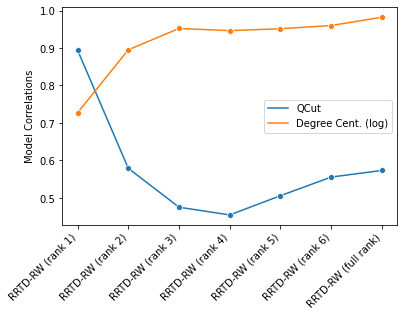

In [7]:
def _plot(df):
    sns.lineplot(
        x='model',
        y='value',
        hue='base_model',
        data=df,
        marker='o',
    )
    plt.ylabel('Model Correlations')
    plt.xlabel('')
    plt.xticks(rotation=45, horizontalalignment='right')
    plt.legend().set_title('')

plt.figure()
_plot(df[
    # Exclude rank 7, since it's full rank, just computed in spectral way.
    # Above assertion checks this.
    (df.model != 'RRTD-RW (rank 7)')
])
analysis.savefig('dc-qcut-rw-spectral.*')

# How does spectral gap relate to the DC<>RW correlation?

In [8]:
df = []
for g in tqdm(graphs):
    c = vector_corr(
        run_models.log_degree_centrality(g)['scores'],
        run_models.rw(g)['scores'],
    )
    df.append(dict(
        spectral_gap=hitting_time.spectral_gap(g),
        dc_rw_corr=c,
    ))

  0%|          | 0/11117 [00:00<?, ?it/s]

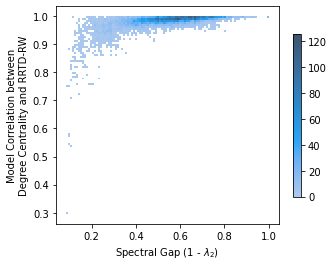

In [9]:
plt.subplots(figsize=(5, 4))
sns.histplot(
    pd.DataFrame(df),
    x='spectral_gap', y='dc_rw_corr',
    bins=(100, 100),
    cbar=True,
    cbar_kws=dict(shrink=.75),
)
plt.xlabel('Spectral Gap (1 - $\lambda_2$)')
plt.ylabel('Model Correlation between\nDegree Centrality and RRTD-RW')
analysis.savefig('dc-rw-corr-vs-spectral-gap.*')